In [1]:
%load_ext tensorboard

#
#
# start Tensorboard with CMD-Shft-P Python:Launch TensorBoard

In [2]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage, NonUniformImage
import numpy as np
import math
from scipy.interpolate import interp1d
from PIL import Image
import cv2
import shutil
import random
import uuid

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.utils import shuffle

import tensorflow as tf

sys.path.append(os.path.join(os.getcwd(),'..'))
from lib import find_nearest_index, FigureSize




In [3]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

In [4]:
NUM_OUTPUTS = 26 # no. of peaks
NUM_BATCHES = 32
NUM_EPOCHS = 100
IMAGE_SIZE = 32
#NUM_TRAIN_LABELS = 2600 # use outpuf of load_images()

TRAIN_DATA_PATH= os.path.join(os.getcwd(), '..','data','train')
TEST_DATA_PATH = os.path.join(os.getcwd(), '..','data','test')
MODEL_PATH = os.path.join(os.getcwd(), '..','data','model.h5')

TESTDATA_TRAINDATA_RATIO = 20./80.

In [5]:
os.makedirs(TRAIN_DATA_PATH, exist_ok=True)
os.makedirs(TEST_DATA_PATH, exist_ok=True)

In [ ]:
NEON_REFERENCE_FILE = os.path.join(os.getcwd(),'..','data','ref','NIST','Ne','neon-exported.csv')
WAVELENGTHS_MIN, WAVELENGTHS_MAX = 4000, 9000
WINDOW = 512
STEPSIZE_MIN, STEPSIZE_MAX, STEPSIZE_N = 0.5, 1.5, 2000
INTENSITY_SCALE = 255

In [7]:
RANDOM_NUMBER = math.pow(10,int(math.log10(STEPSIZE_N *NUM_OUTPUTS))+1)
print (RANDOM_NUMBER)

100000.0


In [8]:
def scale(min_scale, max_scale):
    return random.random()*(max_scale - min_scale)+0.95

In [9]:
def gauss():
    return random.gauss(1.0,0.3)

In [10]:
def build_model():
        
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((IMAGE_SIZE,IMAGE_SIZE,1),input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))         
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Dropout(0.5))
    # model.add(tf.keras.layers.Dense(NUM_TRAIN_LABELS, activation='softmax')) 
    model.add(tf.keras.layers.Dense(NUM_OUTPUTS, activation='softmax')) 

    return model

In [11]:
def load_images(path):
    train_images = []
    train_labels = []

    dir_index = 0
    for directory in sorted(os.listdir(path)):
        if(directory.startswith('.') == False):

            #print("Buchstabe: {}".format(LIST_OF_CHARS[dir_index]))
            for filename in sorted(os.listdir(os.path.join(path, directory))):

                if(filename.startswith('.') == False):
                        
                        image_path = os.path.join(path, directory,filename    )
                        img =cv2.imread(image_path)
                        img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        img = img.reshape([IMAGE_SIZE, IMAGE_SIZE,1])
                        train_images.append(img)
                        train_labels.append(dir_index)
            dir_index = dir_index + 1

    print(len(train_images),train_labels)
    return np.array(train_images)/255, np.array(tf.keras.utils.to_categorical(train_labels,NUM_OUTPUTS))#len(train_labels)))


In [12]:
neon_reference_file = os.path.join(NEON_REFERENCE_FILE)
positions = {'wavelength':2, 'intensity':6, 'selector':1}
selector = '1'
intensity_limit = 1.0
neon_wavelengths = []
neon_intensities = []

with open(neon_reference_file,'r') as neon_f:
    for line in neon_f:
        if line.startswith('#'):
            pass
        else:
            tokens =  line.split(';')
            #print (tokens)
            try:
                if selector in tokens[positions['selector']] :
                    
                    neon_wavelength, neon_intensity = float(tokens[positions['wavelength']]), float(tokens[positions['intensity']])
                    
                    if neon_intensity > intensity_limit :
                        
                        neon_wavelengths.append(neon_wavelength)
                        neon_intensities.append(neon_intensity)
                        
                        print ("{:8.3f} {:10.0f}".format(neon_wavelength, neon_intensity, ))
                    
            except ValueError:
                pass

print (len(neon_wavelengths), len(neon_intensities))
#

4013.752         10
4013.995         20
4020.015         20
4037.262         50
4037.615        150
4037.696         50
4042.327        100
4042.642        500
4045.662         20
4064.036        500
4064.829        150
4068.835        300
4069.243        300
4069.389         50
4079.359         20
4080.148        500
4111.882         10
4112.100        150
4112.694        200
4112.865        100
4126.941         20
4128.072        300
4130.512        200
4131.061        700
4164.808        500
4166.091        300
4173.966         20
4174.367        700
4175.220        600
4175.488        400
4196.415        150
4198.102        700
4232.323         10
4249.538         20
4252.418         20
4252.775         20
4259.739         10
4262.479         20
4267.286         10
4267.724         50
4268.009        700
4269.722        700
4270.225        500
4274.662        500
4275.167         10
4275.559        700
4278.850         50
4279.279        150
4283.242        100
4288.541         50


In [13]:
neon_reference_file = 'linetable-NE.csv'
positions = {'wavelength':0, 'intensity':2}
neon_wavelengths = []
neon_intensities = []

with open(neon_reference_file,'r') as neon_f:
    for line in neon_f:
        if line.startswith('#'):
            pass
        else:
            tokens =  line.split(';')
            print (tokens)
            try:
                neon_wavelength, neon_intensity = float(tokens[positions['wavelength']]), float(tokens[positions['intensity']])
                neon_wavelengths.append(neon_wavelength)
                neon_intensities.append(neon_intensity)
                
                print ("{:8.3f} {:10.0f}".format(neon_wavelength, neon_intensity, ))
                
                        
            except ValueError:
                pass

print (len(neon_wavelengths), len(neon_intensities))
#
# print (neon_wavelengths)

['3417.9035  ', ' Ne I ', ' \n']
['3472.5711  ', ' Ne I ', ' \n']
['3515.1900  ', ' Ne I ', ' \n']
['3593.5263  ', ' Ne I ', ' \n']
['3600.1691  ', ' Ne I ', ' \n']
['4488.0926  ', ' Ne I ', ' \n']
['4636.125   ', ' Ne I ', ' \n']
['4837.3139  ', ' Ne I ', ' \n']
['5005.1587  ', ' Ne I ', ' \n']
['5031.3504  ', ' Ne I ', ' \n']
['5104.7011  ', ' Ne I ', ' \n']
['5113.6724  ', ' Ne I ', ' \n']
['5144.9384  ', ' Ne I ', ' \n']
['5188.6122  ', ' Ne I ', ' \n']
['5330.7775  ', ' Ne I ', ' \n']
['5341.0938  ', ' Ne I ', ' \n']
['5360.0121  ', ' Ne I ', ' \n']
['5400.5617  ', ' Ne I ', ' \n']
['5562.7662  ', ' Ne I ', ' \n']
['5656.5664  ', ' Ne I ', ' \n']
['5689.8163  ', ' Ne I ', ' \n']
['5719.2248  ', ' Ne I ', ' \n']
['5748.2985  ', ' Ne I ', ' \n']
['5764.4188  ', ' Ne I ', ' \n']
['5804.4496  ', ' Ne I ', ' \n']
['5820.1558  ', ' Ne I ', ' \n']
['5852.4878  ', ' Ne I ', '   1573\n']
5852.488       1573
['5881.895   ', ' Ne I ', '   201\n']
5881.895        201
['5944.8342  ', ' Ne I ',

In [14]:
plt.rcParams['figure.figsize'] = FigureSize.NARROW

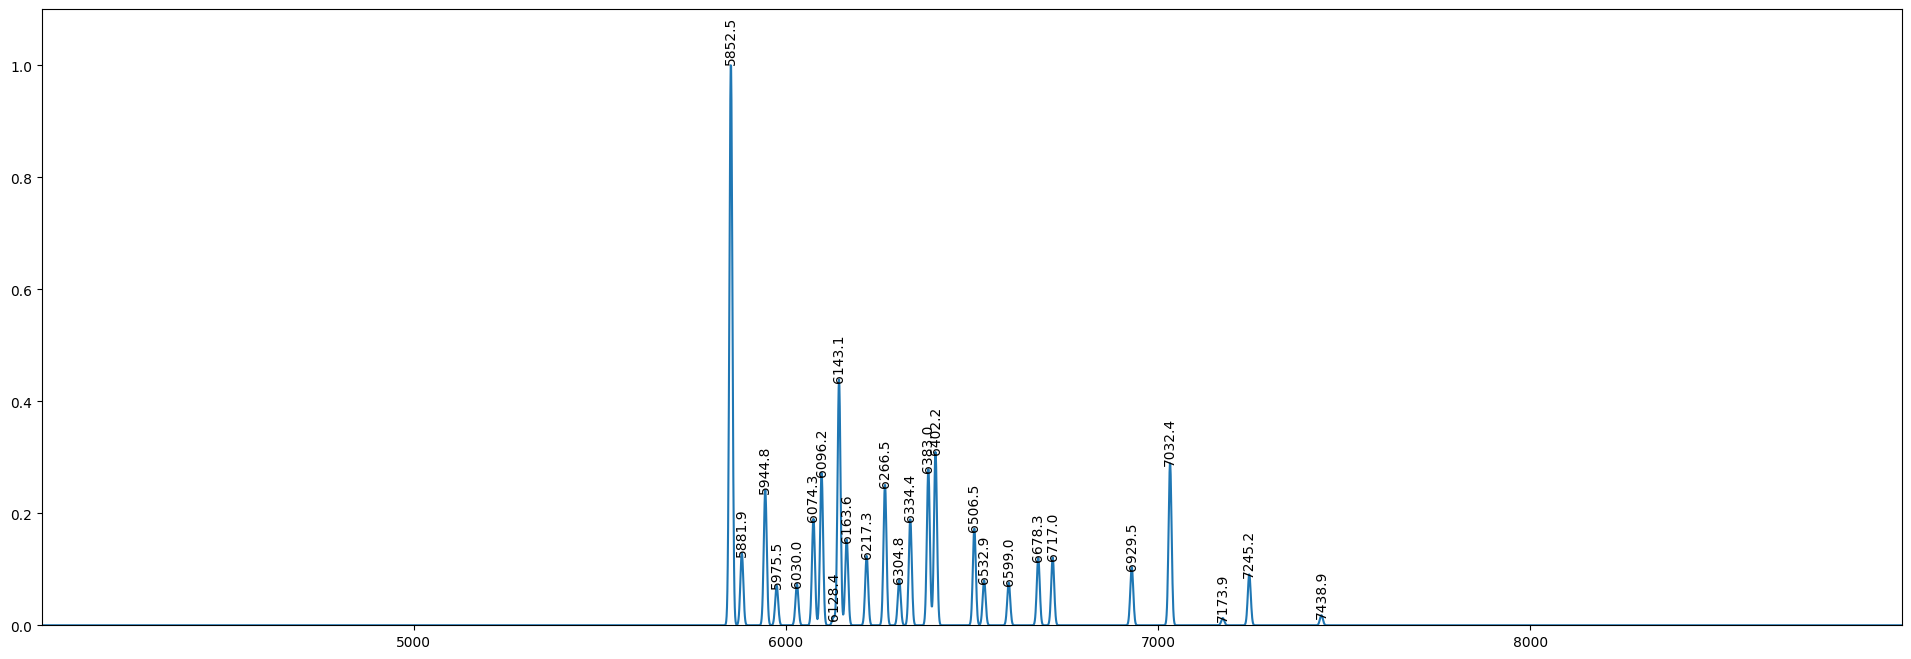

In [15]:
wavelengths = np.array(range(WAVELENGTHS_MIN,WAVELENGTHS_MAX,1))*1.0
intensities = wavelengths * 0.0
sigma = 4.0
k = -2*sigma*sigma
r = math.sqrt(2*math.pi*sigma*sigma)

for neon_w, neon_i, in zip(neon_wavelengths, neon_intensities):

    _e = (wavelengths - neon_w)*(wavelengths- neon_w) / k
    intensities = intensities + np.exp(_e) * neon_i
        

xlim = [wavelengths[1], wavelengths[-2]]
_i1 = find_nearest_index(wavelengths,xlim[0])
_i2 = find_nearest_index(wavelengths,xlim[1])
#print (_i1[0], _i2[0])
max_i = intensities[_i1:_i2].max()
normalized_intensities = intensities / max_i
fig, ax = plt.subplots()

plt.plot(wavelengths, normalized_intensities)
for _nw, _ni in zip(neon_wavelengths, neon_intensities):
    plt.text(_nw,_ni/max_i,"{:6.1f}".format(_nw), rotation=90, horizontalalignment='center')
plt.xlim(xlim)
plt.ylim(0,1.1)
plt.show()

0 5852.4878 5852.48 [1596, 2108]
1 5881.895 5881.89 [1626, 2138]
2 5944.8342 5944.83 [1689, 2201]
3 5975.534 5975.53 [1720, 2232]
4 6029.9971 6029.99 [1774, 2286]
5 6074.3377 6074.33 [1818, 2330]
6 6096.1631 6096.16 [1840, 2352]
7 6128.4499 6128.44 [1872, 2384]
8 6143.0626 6143.06 [1887, 2399]
9 6163.5939 6163.59 [1908, 2420]
10 6217.2812 6217.28 [1961, 2473]
11 6266.495 6266.49 [2010, 2522]
12 6304.789 6304.78 [2049, 2561]
13 6334.4278 6334.42 [2078, 2590]
14 6382.9917 6382.99 [2127, 2639]
15 6402.246 6402.24 [2146, 2658]
16 6506.5281 6506.52 [2251, 2763]
17 6532.8822 6532.88 [2277, 2789]
18 6598.9529 6598.95 [2343, 2855]
19 6678.2764 6678.27 [2422, 2934]
20 6717.043 6717.04 [2461, 2973]
21 6929.4673 6929.46 [2673, 3185]
22 7032.4131 7032.41 [2776, 3288]
23 7173.9381 7173.93 [2918, 3430]
24 7245.1666 7245.16 [2989, 3501]
25 7438.899 7438.89 [3183, 3695]


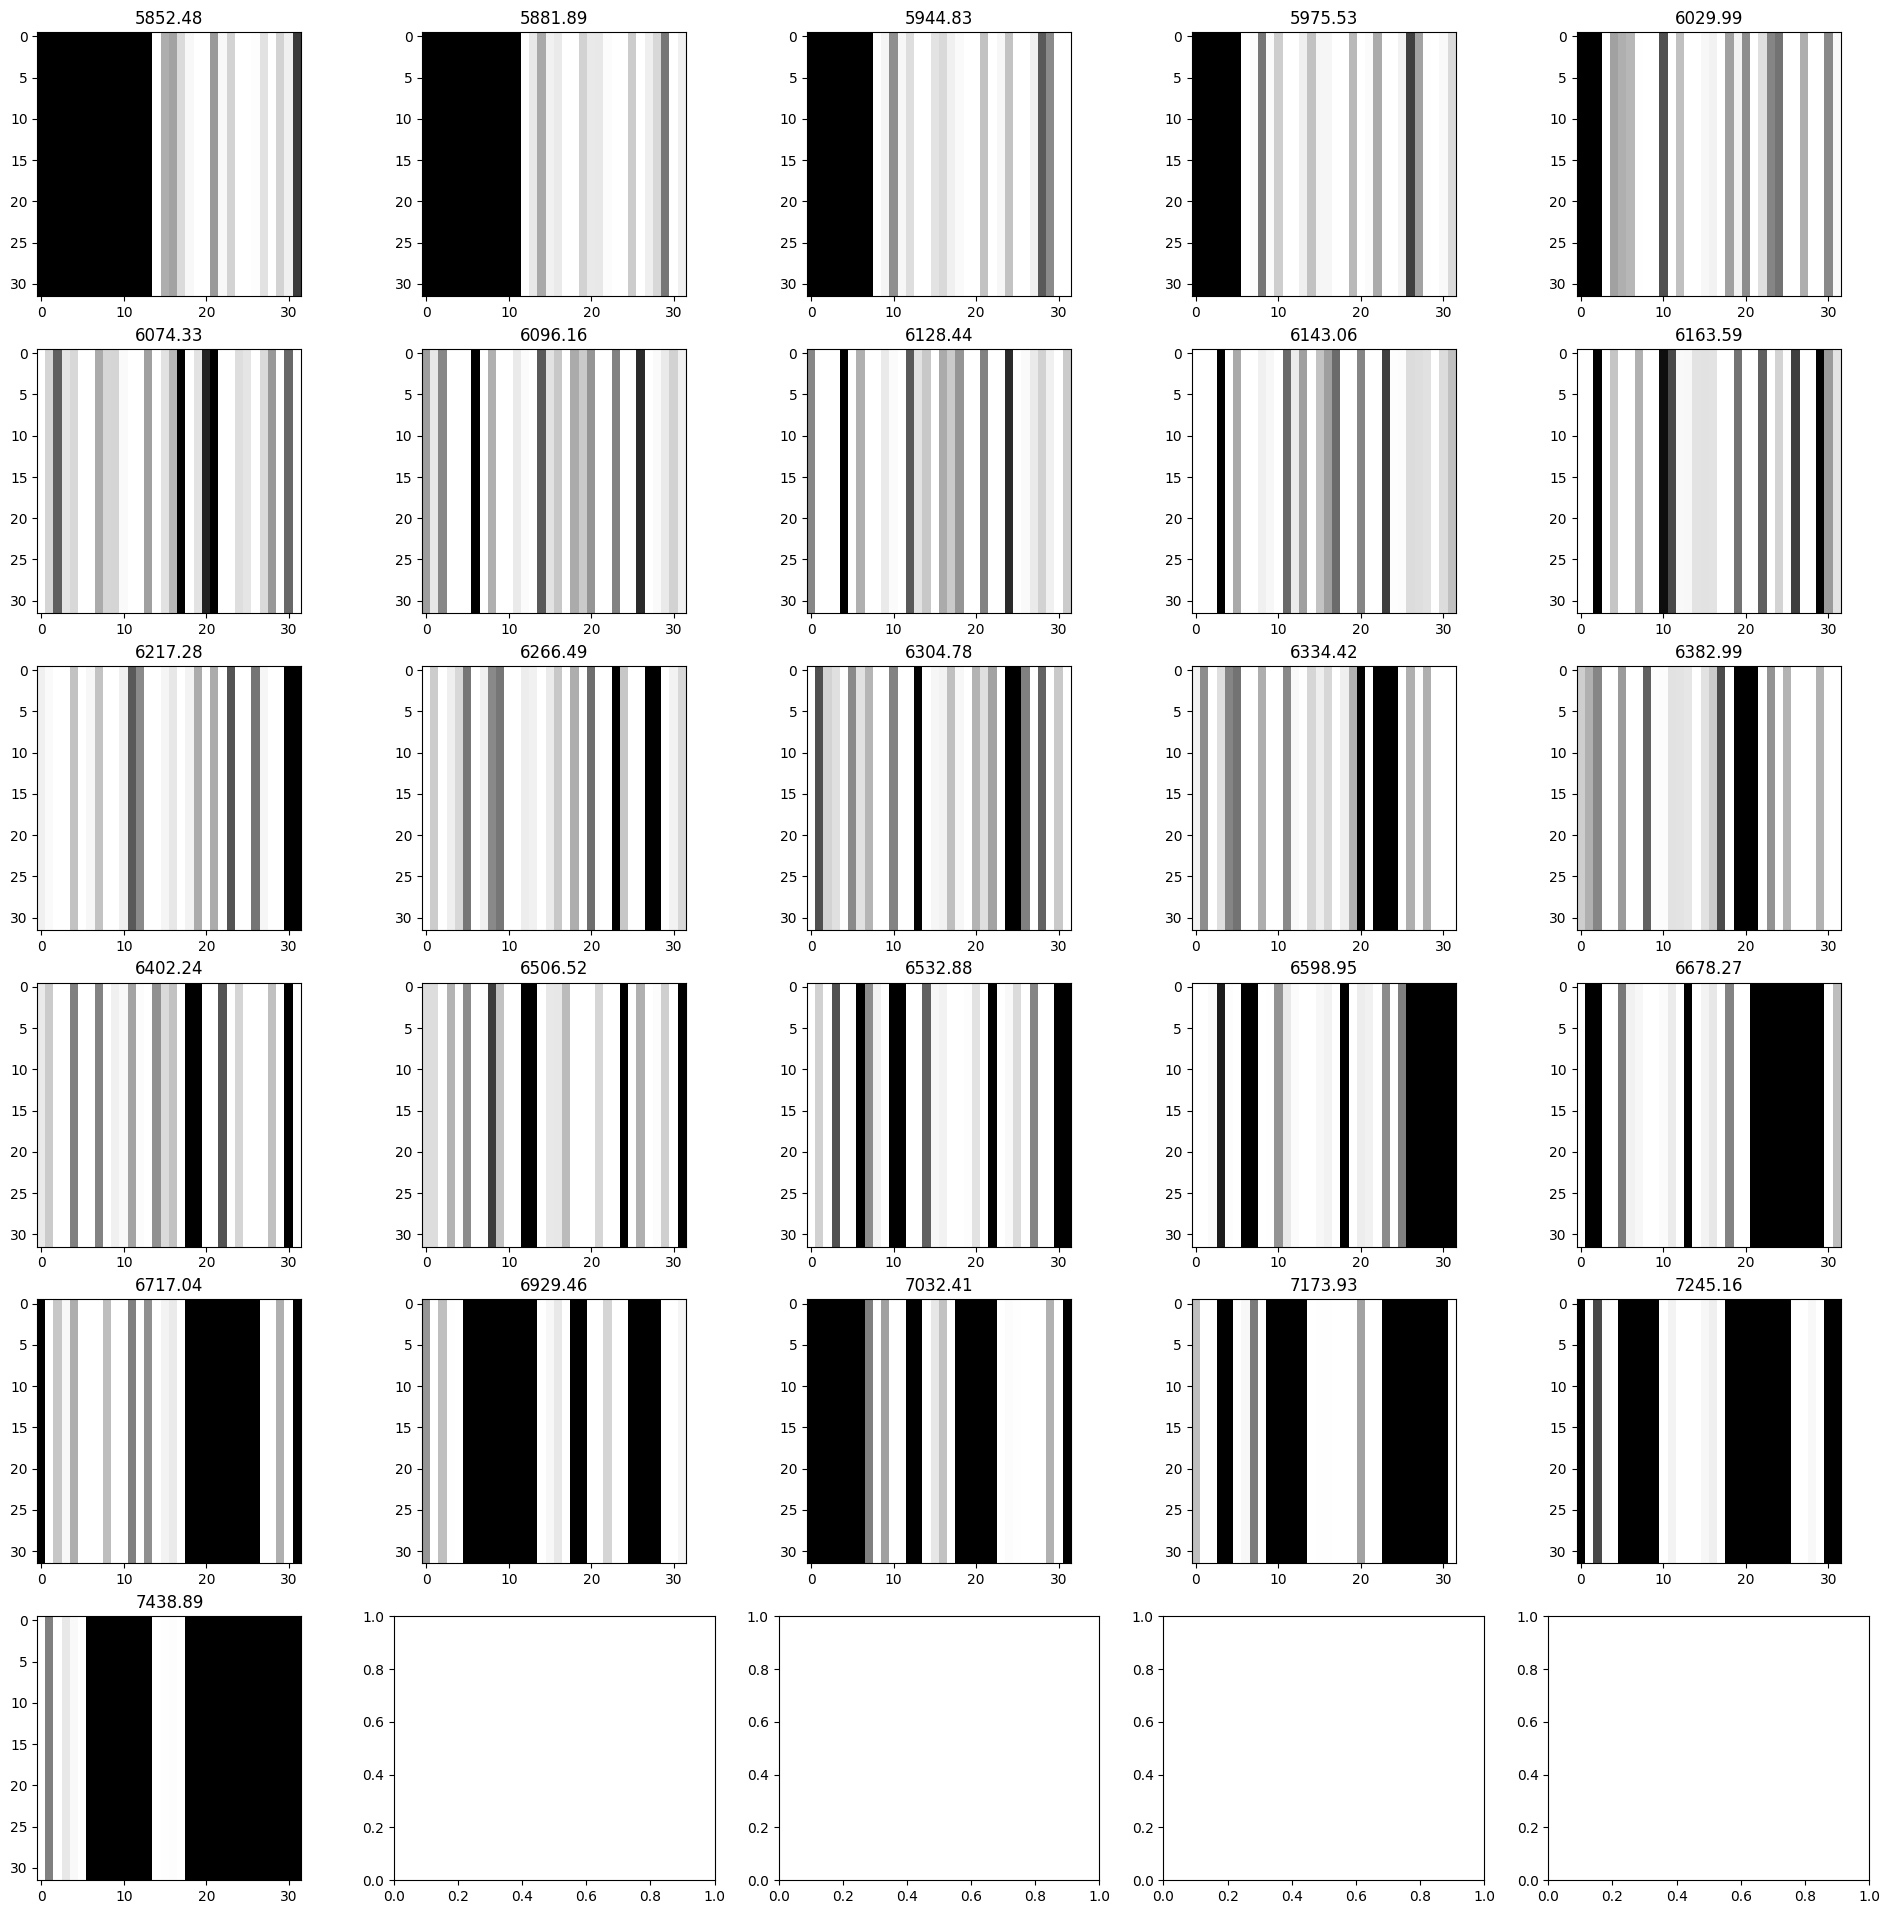

In [19]:
wavelengths = np.array(range(WAVELENGTHS_MIN,WAVELENGTHS_MAX,1))*1.0
pixels = np.array(range(0,len(wavelengths)))
intensities = wavelengths * 0.0
sigma = 4.0
k = -2*sigma*sigma
r = math.sqrt(2*math.pi*sigma*sigma)

for neon_w, neon_i, in zip(neon_wavelengths, neon_intensities):

    _e = (wavelengths - neon_w)*(wavelengths- neon_w) / k
    intensities = intensities + np.exp(_e) * neon_i

xlim = [wavelengths[1], wavelengths[-2]]
_i1 = find_nearest_index(wavelengths,xlim[0])
_i2 = find_nearest_index(wavelengths,xlim[1])
max_i = intensities[_i1:_i2].max()
normalized_intensities = intensities / max_i

ny = WINDOW
nx = len(normalized_intensities)

twod = np.zeros((ny, nx))
for i in range(ny):
    twod[i] = normalized_intensities*-1+1.0

ylim = [0,ny]

n_cols = 5
n_rows = math.ceil(len(neon_wavelengths)/n_cols)

window = WINDOW
window_h = int(window/2)
image_size = [IMAGE_SIZE,IMAGE_SIZE]

plt.rcParams['figure.figsize'] = FigureSize.LARGE
fig, axes = plt.subplots(n_rows, n_cols,sharex=False, sharey=False)

i_row = 0
i_col = 0

for index in range(0,len(neon_wavelengths)):
    neon_w = neon_wavelengths[index]
    
    _xlim = [
            find_nearest_index(wavelengths,neon_w)-window_h,
            find_nearest_index(wavelengths,neon_w)+window_h,
    ]
    _ylim = [0,ny]
    _twod = twod[_ylim[0]:_ylim[1], _xlim[0]:_xlim[1]]
    wavelength_text = str(int(neon_w*100)/100)
    print(index, neon_w, wavelength_text, _xlim)
    _res = cv2.resize(np.uint8(_twod * INTENSITY_SCALE), dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)

    if n_cols == 1:
        axes[i_row].imshow(_res, cmap='gray')
        axes[i_row].set_title(wavelength_text)
        #axes[i_row].set_ylim(_ylim)
        #axes[i_row].set_xlim(0,_xlim[1]-_xlim[0])
        print (i_row, wavelength_text, _xlim)
        i_row += 1
    else:
        axes[i_row, i_col].imshow(_res, cmap='gray')
        axes[i_row, i_col].set_title(wavelength_text)
        #axes[i_row, i_col].set_ylim(_ylim)
        #axes[i_row, i_col].set_xlim(0,_xlim[1]-_xlim[0])

        i_col += 1
        if i_col >= n_cols:
            i_col = 0
            i_row +=1
plt.show()

In [17]:
for neon_w in neon_wavelengths:
    wavelength_text = str(int(neon_w*100)/100)
    p = os.path.join(TRAIN_DATA_PATH, wavelength_text)
    try:
        shutil.rmtree(p, ignore_errors=True)
        
    except FileNotFoundError:
        print ("skipping "+p)
    os.makedirs(p) # ensure creation of parent dirs

In [18]:
sigma = 4.0
k = -2*sigma*sigma
r = math.sqrt(2*math.pi*sigma*sigma)

xlim = [wavelengths[1], wavelengths[-2]]
ny = WINDOW
nx = len(normalized_intensities)
ylim = [0,ny]

window_h = int(WINDOW/2)
image_size = [IMAGE_SIZE,IMAGE_SIZE]

filename_counter = [0] * len (neon_wavelengths)

min_stepsize = STEPSIZE_MIN
max_stepsize = STEPSIZE_MAX
n_steps = STEPSIZE_N
d_step = (max_stepsize - min_stepsize)/n_steps

stepsizes = np.array(range(n_steps))*d_step+min_stepsize
#print (stepsizes)
nbins = WAVELENGTHS_MAX - WAVELENGTHS_MIN
for stepsize in stepsizes:
    wavelengths = np.array(range(nbins))*stepsize+WAVELENGTHS_MIN #   np.array(range(4000,9000,stepsize))*1.0
    
    intensities = np.zeros(nbins)

    for neon_w, neon_i, in zip(neon_wavelengths, neon_intensities):
        _neon_w = neon_w+random.gauss(0,1.5)
        _e = (wavelengths - _neon_w)*(wavelengths- _neon_w) / k
        intensities = intensities + np.exp(_e) * neon_i*gauss() # scale(0.9,1.0)

    max_i = intensities[1:-2].max()
    normalized_intensities = intensities / max_i

    twod = np.zeros((ny, nx))
    for i in range(ny):
        twod[i] = normalized_intensities*-1+1.0


    for index in range(0,len(neon_wavelengths)):
        neon_w = neon_wavelengths[index]
        
        _xlim = [
            find_nearest_index(wavelengths,neon_w)-window_h,
            find_nearest_index(wavelengths,neon_w)+window_h,
        ]
        _ylim = [0,ny]
        _twod = twod[_ylim[0]:_ylim[1], _xlim[0]:_xlim[1]]
        wavelength_text = str(int(neon_w*100)/100)
        
        res = cv2.resize(np.uint8(_twod * INTENSITY_SCALE), dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        img = Image.fromarray(res)

        prob = random.random()
        
        if prob < TESTDATA_TRAINDATA_RATIO:
            p = os.path.join(TEST_DATA_PATH,'{:s}.{:06d}.BMP'.format(wavelength_text,filename_counter[index]))
        else:
            p = os.path.join(TRAIN_DATA_PATH,wavelength_text,'{:s}.{:06d}.BMP'.format(wavelength_text,filename_counter[index]))

        img.save(p, format='BMP')
        
        filename_counter[index] += 1


    

KeyboardInterrupt: 

In [ ]:
train_images, train_labels  = load_images(TRAIN_DATA_PATH)


train_images, train_labels  = shuffle(train_images,train_labels,random_state=21)
print (len(train_labels))
xTrain, xTest, yTrain, yTest = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 0)
optimizer = tf.keras.optimizers.Adam()

model = build_model()
model.summary()
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ["accuracy"])
tf_callback = tf.keras.callbacks.TensorBoard(log_dir="logs",histogram_freq=5)
model.fit(xTrain,yTrain, epochs=NUM_EPOCHS,batch_size=NUM_BATCHES, callbacks=[tf_callback], verbose=1,validation_split=0.2)

results = model.evaluate(xTest,yTest,verbose=1)
print("--- Ergebnisse {} ----".format(TRAIN_DATA_PATH))
print('Evaluation / Loss {}, Acc:{}'.format(results[0],results[1]))
export_path = MODEL_PATH

model.save(export_path)
print("💾 Modell gespeichert")